In [5]:
from pathlib import Path
import json, random, numpy as np
import cv2, matplotlib.pyplot as plt

PROJECT   = Path.cwd().parent          # ← one level up from notebooks/
RAW_DIR   = PROJECT / "data" / "raw"
LABEL_DIR = PROJECT / "data" / "labels"
TILE      = 100


In [6]:
print(Path.cwd())           # where the notebook is running
print(RAW_DIR.resolve())    # where it thinks data/raw is
print(RAW_DIR.exists())     # False → path missing

C:\Users\modar\Desktop\lamppost-dataset\notebooks
C:\Users\modar\Desktop\lamppost-dataset\data\raw
True


In [7]:
def load_pair(img_file: Path):
    jfn = LABEL_DIR / f"{img_file.stem}.json"
    if not jfn.exists():          # ← skip un-annotated picture
        return None, None
    img = cv2.cvtColor(cv2.imread(str(img_file)), cv2.COLOR_BGR2RGB)
    lbl = np.array(json.loads(jfn.read_text())["labels"], dtype=np.int8)
    return img, lbl


In [8]:
stats = []
for img_file in sorted(RAW_DIR.glob("*.*g")):
    img, lbl = load_pair(img_file)
    if lbl is None:                       # no JSON yet
        continue
    n_pos = int((lbl == 1).sum())
    n_neg = int((lbl == -1).sum())
    stats.append((img_file.name, n_pos, n_neg))



# tabulate
import pandas as pd
df = pd.DataFrame(stats, columns=["image", "ROI", "background"])
df["total"]   = df["ROI"] + df["background"]
df["roi_pct"] = df["ROI"] / df["total"] * 100
df.head()


,image,ROI,background,total,roi_pct
0,20250423_113505.jpg,47,673,720,6.527778
1,20250423_113518.jpg,52,668,720,7.222222
2,20250423_113537.jpg,53,667,720,7.361111
3,20250423_113549.jpg,62,658,720,8.611111
4,20250423_113602.jpg,66,654,720,9.166667


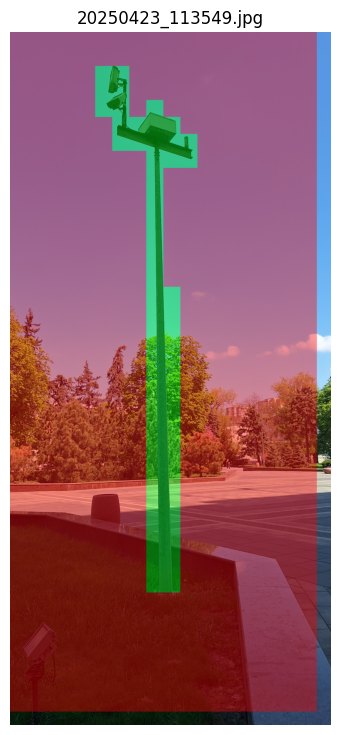

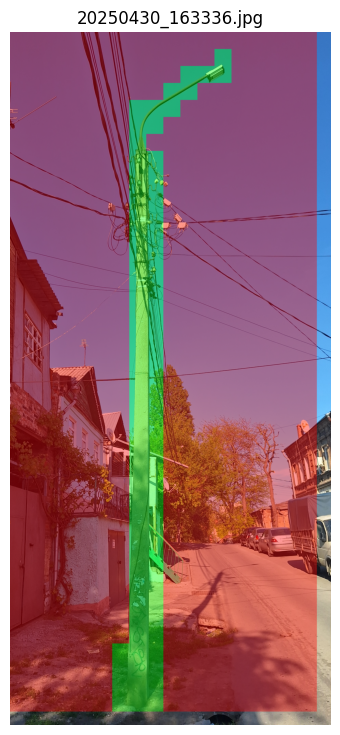

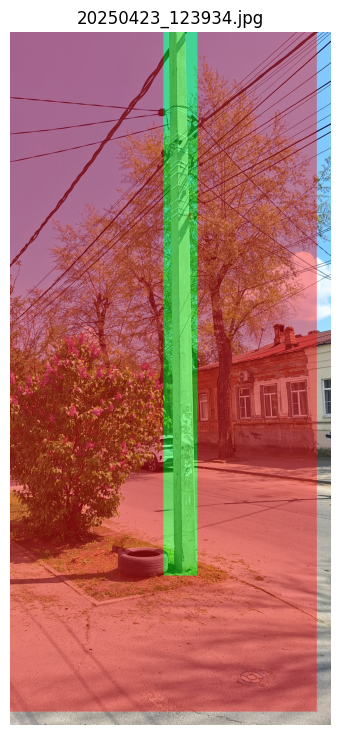

In [9]:
import random, matplotlib.pyplot as plt, cv2

def show_overlay(img_file: Path, lbl: np.ndarray):
    img = cv2.cvtColor(cv2.imread(str(img_file)), cv2.COLOR_BGR2RGB)
    overlay = img.copy()
    for r in range(lbl.shape[0]):
        for c in range(lbl.shape[1]):
            v = lbl[r, c]
            if v == 0:       # ignore
                continue
            colour = (0,255,0,120) if v == 1 else (255,0,0,120)
            y0, y1 = r*TILE, (r+1)*TILE
            x0, x1 = c*TILE, (c+1)*TILE
            cv2.rectangle(overlay, (x0,y0), (x1,y1), colour[:3], -1)

    plt.figure(figsize=(6,9))
    plt.title(img_file.name)
    plt.imshow(cv2.addWeighted(overlay, 0.4, img, 0.6, 0))
    plt.axis("off")
    plt.show()

for img_file in random.sample(list(RAW_DIR.glob("*.*g")), 3):
    _, lbl = load_pair(img_file)
    if lbl is not None:
        show_overlay(img_file, lbl)

In [10]:
# flag images with no ROI or suspiciously high ROI %
bad = df.query("ROI == 0 or roi_pct > 40")

if bad.empty:
    print("✓ all annotated images look reasonable.")
else:
    display(bad)   # review these in the GUI


✓ all annotated images look reasonable.
